In [1]:
import torch
import importlib

In [2]:
import torchvision
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=['0'],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

In [3]:
import torch
import matplotlib.pyplot as plt

BATCH_SIZE = 4 # increase / decrease according to GPU memeory
RESIZE_TO = 512 # resize the image for training and transforms
NUM_EPOCHS = 1 # number of epochs to train for

DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# training images and XML files directory
TRAIN_DIR = 'data/out_rgb'
# validation images and XML files directory
VALID_DIR = 'data/out_rgb'

# classes: 0 index is reserved for background
CLASSES = [
    '0', '1', '2', '3', '4'
]
NUM_CLASSES = 5

# whether to visualize images after crearing the data loaders
VISUALIZE_TRANSFORMED_IMAGES = False

# location to save model and plots
# OUT_DIR = '../outputs'
OUT_DIR = 'outputs'
SAVE_PLOTS_EPOCH = 2 # save loss plots after these many epochs
SAVE_MODEL_EPOCH = 2 # save model after these many epochs

In [4]:
import albumentations as A
import cv2
import numpy as np
from albumentations.pytorch import ToTensorV2
from config import DEVICE, CLASSES as classes
# this class keeps track of the training and validation loss values...
# ... and helps to get the average for each epoch as well
class Averager:
    def __init__(self):
        self.current_total = 0.0
        self.iterations = 0.0
        
    def send(self, value):
        self.current_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.current_total / self.iterations
    
    def reset(self):
        self.current_total = 0.0
        self.iterations = 0.0

In [5]:
def collate_fn(batch):
    """
    To handle the data loading as different images may have different number 
    of objects and to handle varying size tensors as well.
    """
    return tuple(zip(*batch))

In [6]:
# define the training tranforms
def get_train_transform():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc',
        'label_fields': ['labels']
    })

def get_train_transform_without_boxes():
    return A.Compose([
        A.Flip(0.5),
        A.RandomRotate90(0.5),
        A.MotionBlur(p=0.2),
        A.MedianBlur(blur_limit=3, p=0.1),
        A.Blur(blur_limit=3, p=0.1),
        ToTensorV2(p=1.0)
    ])

# define the validation transforms
def get_valid_transform():
    return A.Compose([
        ToTensorV2(p=1.0),
    ], bbox_params={
        'format': 'pascal_voc', 
        'label_fields': ['labels']
    })

In [7]:
def show_tranformed_image(train_loader):
    """
    This function shows the transformed images from the `train_loader`.
    Helps to check whether the tranformed images along with the corresponding
    labels are correct or not.
    Only runs if `VISUALIZE_TRANSFORMED_IMAGES = True` in config.py.
    """
    if len(train_loader) > 0:
        for i in range(1):
            images, targets = next(iter(train_loader))
            images = list(image.to(DEVICE) for image in images)
            targets = [{k: v.to(DEVICE) for k, v in t.items()} for t in targets]
            boxes = targets[i]['boxes'].cpu().numpy().astype(np.int32)
            sample = images[i].permute(1, 2, 0).cpu().numpy()
            for box in boxes:
                cv2.rectangle(sample,
                            (box[0], box[1]),
                            (box[2], box[3]),
                            (0, 0, 255), 2)
            cv2.imshow('Transformed image', sample)
            cv2.waitKey(0)
            cv2.destroyAllWindows()

In [8]:
import torch
import cv2
import numpy as np
import os
import glob as glob
from xml.etree import ElementTree as et
import json
# from config import CLASSES, RESIZE_TO, TRAIN_DIR, VALID_DIR, BATCH_SIZE

# from config import CLASSES, RESIZE_TO, BATCH_SIZE
from torch.utils.data import Dataset, DataLoader
# from utils import collate_fn, get_train_transform, get_valid_transform

In [9]:
# the dataset class
class MicrocontrollerDataset(Dataset):
    def __init__(self, dir_path, width, height, classes, transforms=None, transforms_without_boxes=None):
        self.transforms_without_boxes = transforms_without_boxes
        self.transforms = transforms
        self.dir_path = dir_path
        self.height = height
        self.width = width
        self.classes = classes
        
        # get all the image paths in sorted order    
        self.image_paths = glob.glob(f"{self.dir_path}/*.png")
        self.all_images = [image_path.split('/')[-1].split('.')[0] for image_path in self.image_paths]
        self.all_images = sorted(self.all_images)
        self.all_classes = set()

        # FileNames Dictionary
        self.filenames = dict()
        for sub_dir, dir_name, files in os.walk("data/out_bbox/"):
            for file in files:
                try:
                    with open("data/out_bbox/" + file, 'r') as fp:
                        file = file.split('.')[0]
                        self.filenames[file] = json.load(fp)
                        self.all_classes.update(self.filenames[file]["vehicle_class"])
                except Exception as e:
                    pass
                
    def check_bounding_boxes(self, box_coordinates):
        box_coords = []
        for coordinate in box_coordinates:
            if coordinate < 1:
                box_coords.append(1)
            elif coordinate > self.width:
                box_coords.append(self.width)
            else:
                box_coords.append(coordinate)
        if box_coords[0] == box_coords[2]:
            if box_coords[2] != self.width:
                box_coords[2] += 5
            else:
                box_coords[0] -= 5
        if box_coords[1] == box_coords[3]:
            if box_coords[3] != self.width:
                box_coords[3] += 5
            else:
                box_coords[1] -= 5
        return box_coords
                    
    def __getitem__(self, idx):
        # capture the image name and the full image path
        image_name = self.all_images[idx]
        image_path = os.path.join(self.dir_path, image_name + '.png')
        # read the image
        # print(image_path)
        # image = cv2.imread(image_path, cv2.COLOR_BGR2RGB)
        image = cv2.imread(image_path)
        # plt.imshow(image)
        # convert BGR to RGB color format
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image_resized = cv2.resize(image, (self.width, self.height))
        image_resized /= 255.0
        # plt.imshow(image_resized)
        
        # get the height and width of the image
        image_width = image.shape[1]
        image_height = image.shape[0]
        
        image_annotation_dict = self.filenames[image_name]
        
        boxes = []
        if image_annotation_dict["bboxes"]:
            for box_coordinates in self.filenames[image_name]["bboxes"]:
                if box_coordinates:
                    xmin = box_coordinates[0][0]
                    ymin = box_coordinates[0][1]
                    xmax = box_coordinates[1][0]
                    ymax = box_coordinates[1][1]
                    
                    xmin_final = (xmin/image_width)*self.width
                    xmax_final = (xmax/image_width)*self.width
                    ymin_final = (ymin/image_height)*self.height
                    ymax_final = (ymax/image_height)*self.height
                    box_coordinates_loc = [xmin_final, ymin_final, xmax_final, ymax_final]
                    boxes.append(self.check_bounding_boxes(box_coordinates_loc))
                    # boxes.append([xmin_final, ymin_final, xmax_final, ymax_final])
        labels_orig = image_annotation_dict["vehicle_class"]
        labels = []
        for label in labels_orig:
            labels.append(label + 1)

        num_objs = len(boxes)
        
        if not boxes:
            # print("Came Inside")
            boxes = torch.zeros((0,4), dtype=torch.float32)
            labels = torch.zeros(0, dtype=torch.int64)
            area = torch.zeros(0, dtype=torch.float32)
        else:
            # bounding box to tensor
            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # print(boxes)
            # labels to tensor
            labels = torch.as_tensor(labels, dtype=torch.int64)
            # area of the bounding boxes
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        
        # no crowd instances
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        # prepare the final `target` dictionary
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        image_id = torch.tensor([idx])
        target["image_id"] = image_id
        # apply the image transforms
        # print(labels)
        # print(boxes)
        if self.transforms:
            # if num_objs == 0:
            #     print("Before Transformation:", target['boxes'])
            if num_objs != 0:
                try:
                    sample = self.transforms(image = image_resized,
                                             bboxes = boxes,
                                             labels = labels)
                    target_boxes = []
                    for box in sample['bboxes']:
                        target_box = []
                        for box_coordinate in box:
                            if box_coordinate < 1:
                                target_box.append(0)
                            elif box_coordinate > self.width:
                                target_box.append(self.width)
                            else:
                                target_box.append(box_coordinate)
                        if target_box[0] == target_box[2]:
                            if target_box[2] != self.width:
                                target_box[2] += 5
                            else:
                                target_box[0] -= 5
                        if target_box[3] == target_box[1]:
                            if target_box[3] != self.height:
                                target_box[3] += 5
                            else:
                                target_box[1] -= 5
                        target_boxes.append(target_box)
                    # target['boxes'] = torch.Tensor(sample['bboxes'])
                    target['boxes'] = torch.Tensor(target_boxes)
                except:
                    sample = dict()
                    sample['image'] = torch.tensor(image_resized).permute(2,0,1)
                    print("Boxes Exception:", boxes)
            else:
                sample = self.transforms_without_boxes(image = image_resized)
                target['boxes'] = torch.zeros((0,4), dtype=torch.float32)
                target['labels'] = torch.zeros(0, dtype=torch.int64)
                target['area'] = torch.zeros(0, dtype=torch.float32)
            image_resized = sample['image']
        return image_resized, target

    def __len__(self):
        return len(self.all_images)

In [10]:
# prepare the final datasets and data loaders
train_dataset = MicrocontrollerDataset(TRAIN_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_train_transform(), get_train_transform_without_boxes())
valid_dataset = MicrocontrollerDataset(VALID_DIR, RESIZE_TO, RESIZE_TO, CLASSES, get_valid_transform(), get_train_transform_without_boxes())
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=0,
    collate_fn=collate_fn
)
valid_loader = DataLoader(
    valid_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    collate_fn=collate_fn
)
print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(valid_dataset)}\n")

Number of training samples: 2779
Number of validation samples: 2779



In [11]:
train_dataset.all_classes

{0, 1, 2, 3}

In [12]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
def create_model(num_classes):
    # load Faster RCNN pre-trained model
    # model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, rpn_nms_thresh=0.0, box_score_thresh=0.0, box_detections_per_img=100)
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True, rpn_nms_thresh=0.0, box_score_thresh=0.0)
    # get the number of input features 
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # define a new head for the detector with required number of classes
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

In [13]:
image_tensor_list = list(train_dataset[0][0].unsqueeze(dim=0).float()) + list(train_dataset[1][0].unsqueeze(dim=0).float())
# image_tensor_list = list(train_dataset[0][0].unsqueeze(dim=0).float())

In [14]:
train_dataset[0]

(tensor([[[0.8693, 0.8668, 0.8638,  ..., 0.6392, 0.6336, 0.6366],
          [0.8697, 0.8671, 0.8667,  ..., 0.6461, 0.6531, 0.6124],
          [0.8705, 0.8688, 0.8676,  ..., 0.6388, 0.6471, 0.6383],
          ...,
          [0.8030, 0.8091, 0.8103,  ..., 0.5786, 0.5478, 0.5165],
          [0.9779, 0.9786, 0.9812,  ..., 0.5842, 0.6133, 0.5908],
          [0.4893, 0.4908, 0.5111,  ..., 0.5605, 0.5950, 0.5604]],
 
         [[0.8157, 0.8157, 0.8140,  ..., 0.5348, 0.5386, 0.5410],
          [0.8187, 0.8157, 0.8154,  ..., 0.5534, 0.5528, 0.5121],
          [0.8159, 0.8174, 0.8157,  ..., 0.5544, 0.5436, 0.5372],
          ...,
          [0.6819, 0.6847, 0.6864,  ..., 0.4898, 0.4663, 0.4424],
          [0.7966, 0.7944, 0.7976,  ..., 0.4959, 0.5327, 0.5031],
          [0.3024, 0.3017, 0.3196,  ..., 0.4800, 0.5157, 0.4947]],
 
         [[0.7684, 0.7658, 0.7653,  ..., 0.4409, 0.4505, 0.4447],
          [0.7686, 0.7678, 0.7665,  ..., 0.4554, 0.4491, 0.4170],
          [0.7688, 0.7704, 0.7686,  ...,

In [15]:
len(image_tensor_list)

2

In [16]:
len(image_tensor_list)

2

In [17]:
image_tensors = torch.concat((train_dataset[0][0].unsqueeze(dim=0).float(), train_dataset[1][0].unsqueeze(dim=0).float()), dim=0)

In [18]:
image_tensors.shape

torch.Size([2, 3, 512, 512])

In [19]:
NUM_CLASSES

5

In [20]:
model = create_model(num_classes=NUM_CLASSES)

In [21]:
# model

In [22]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.load_state_dict(torch.load(
    'outputs/model10.pth', map_location=device
))

<All keys matched successfully>

In [23]:
model.eval()
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

# model.fc0.conv2.register_forward_hook(get_activation('fc0.conv2'))
# model.fc1.conv2.register_forward_hook(get_activation('fc1.conv2'))

model.rpn.head.cls_logits.register_forward_hook(get_activation('rpn.head.cls_logits'))
model.rpn.head.bbox_pred.register_forward_hook(get_activation('rpn.head.bbox_pred'))
model.roi_heads.box_roi_pool.register_forward_hook(get_activation('roi_heads.box_roi_pool'))
model.rpn.head.conv.register_forward_hook(get_activation('rpn.head.conv'))
model.backbone.body.conv1.register_forward_hook(get_activation('backbone.body.conv1'))
# model.transform.register_forward_hook(get_activation('transform'))

# output = model(image_tensor_list)
output = model(image_tensors)
print(activation['rpn.head.cls_logits'].shape)
print(activation['rpn.head.bbox_pred'].shape)
print(activation['roi_heads.box_roi_pool'].shape)
print(activation['rpn.head.conv'].shape)
print(activation['backbone.body.conv1'].shape)
# print(activation['transform'])

X Type: <class 'torch.Tensor'> X Shape: torch.Size([2, 3, 800, 800])
************************************************** Len (features): 5 Features Shape: odict_keys(['0', '1', '2', '3', 'pool']) Image Shape: torch.Size([2, 3, 800, 800]) **************************************************


/home/karthikragunath/anaconda3/envs/semantic_scene_understanding/lib/python3.8/site-packages/torch/functional.py:445: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/TensorShape.cpp:2157.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Num Images (Anchors): 2
Old Proposals Shape: torch.Size([319764, 1, 4])
New Proposals Shape: torch.Size([2, 159882, 4])
porposals shape: torch.Size([2, 4507, 4]) objectness_prob shape: torch.Size([2, 4507]) levels shape: torch.Size([2, 4507]) image_shapes: [(800, 800), (800, 800)]
************************************************** Boxes Shape: 2 torch.Size([65, 4]) torch.Size([55, 4]) Scores Shape: 2 torch.Size([65]) torch.Size([55]) Proposals Shape: torch.Size([2, 159882, 4]) **************************************************
Box Features Shape: torch.Size([120, 1024])
X Shape: torch.Size([120, 1024])
Score Values: tensor([[-6.3770e-01,  6.1104e+00,  2.1705e-02, -1.9404e+00, -4.0860e+00],
        [ 6.0878e+00,  1.6507e+00, -3.6159e+00, -1.7959e+00, -2.5060e+00],
        [ 2.9755e-01,  2.3952e+00,  2.8874e+00, -2.2963e+00, -4.2564e+00],
        [ 4.3476e+00, -2.1449e+00, -4.4590e+00, -6.4766e-01,  1.3908e+00],
        [ 6.1507e+00, -2.0083e+00, -5.2569e+00, -9.1959e-01,  9.6800e-01],
 

In [24]:
test = torch.tensor([[1,2,3],[4,5,6]])
test[:, None, :].shape

torch.Size([2, 1, 3])

In [25]:
output

[{'boxes': tensor([[159.3288, 216.6688, 196.2327, 250.1567],
          [125.9265, 238.3101, 157.8434, 254.4318],
          [124.8882, 238.3264, 157.7585, 254.4108],
          [209.3028, 243.8449, 213.0858, 251.4275],
          [ 90.3823, 235.0421, 105.2807, 246.2789],
          [134.5491, 218.7561, 208.1981, 253.3988],
          [180.9086, 237.9128, 194.1959, 248.5686],
          [ 90.6786, 235.3472, 105.3948, 246.4179],
          [122.9607, 230.2456, 156.9689, 256.2593],
          [209.4807, 243.8600, 212.9194, 251.5636],
          [205.1512, 247.2862, 209.3820, 253.0028],
          [129.8430, 218.4434, 207.2652, 253.5214],
          [164.3703, 237.2815, 184.0384, 249.5013],
          [159.6981, 218.6761, 195.4225, 250.6217],
          [210.2756, 251.6226, 214.1971, 257.1788],
          [ 70.5316, 231.8130, 116.5905, 250.3591],
          [ 77.2575, 232.5922,  95.7237, 243.6695],
          [209.2154, 243.3724, 213.3757, 251.8964],
          [ 91.8288, 234.9233, 105.7242, 245.6126],
   

In [26]:
print(output[0]['boxes'].shape, output[0]['labels'].shape, output[0]['scores'].shape, output[0]['feature_vector'].shape, output[0]['proposals'].shape)

KeyError: 'proposals'

In [ ]:
train_dataset[0][0].shape

In [ ]:
# numpy_image = train_dataset[0][0].numpy()

In [ ]:
# numpy_image.shape

In [ ]:
# numpy_image = np.transpose(numpy_image, (1, 2, 0)).astype(np.float)

In [ ]:
# numpy_image.shape

In [ ]:
original_image_tensor = train_dataset[0][0]

In [ ]:
original_image_tensor.shape

In [ ]:
# original_image_tensor = original_image_tensor.permute(1,2,0)

In [ ]:
# original_image_tensor.shape

In [ ]:
import torchvision.transforms as T
input_transform = T.Compose([
                          # T.ToTensor(),
                          # T.Resize(size=(width, height)),
                          # T.Grayscale(),
                          # T.Normalize((0.5), (0.5)),
                          # T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
                          T.Resize(size=(800,800))
                          ])

In [ ]:
# transformed_image = input_transform(numpy_image)
transformed_image = input_transform(original_image_tensor)

In [ ]:
transformed_image.shape

In [ ]:
proposals = output[0]['proposals']

In [ ]:
proposals[0:3].shape

In [ ]:
plt.imshow(transformed_image.permute(1, 2, 0))

In [ ]:
transformed_image.shape

In [ ]:
from torchvision.utils import save_image
save_image(transformed_image, 'saved_image.png')

In [ ]:
# transformed_image_cv = cv2.cvtColor(transformed_image, cv2.COLOR_GRAY2BGR)

In [ ]:
transformed_cv_image = cv2.imread('saved_image.png')

In [ ]:
draw_boxes = proposals

In [43]:
draw_boxes

tensor([[ -17.2143,   -4.7248,    8.8413,    7.0922],
        [ -14.5118,  -13.3096,    8.9846,    8.7013],
        [  -4.2632,  -20.5517,    7.2093,    4.5122],
        ...,
        [ 400.1337,  597.3806, 1249.4646,  859.1666],
        [ 523.4047,  477.6804,  985.3783,  972.4048],
        [ 632.4822,  393.1936,  873.8715, 1152.2560]])

In [44]:
draw_boxes.shape

torch.Size([159882, 4])

In [45]:
draw_boxes = proposals[-100:]
test_image = transformed_cv_image.copy()
for j, box in enumerate(draw_boxes):
    for i in range(4):
        if int(box[i]) <= 0:
            box[i] = 0
        if int(box[i]) >= 800:
            box[i] = 800
    cv2.rectangle(test_image,
                (int(box[0]), int(box[1])),
                (int(box[2]), int(box[3])),
                (0, 0, 255), 2)

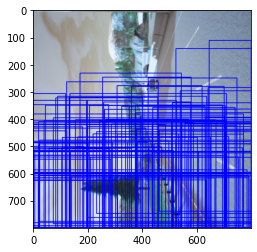

In [46]:
plt.imshow(test_image)

In [47]:
draw_boxes

tensor([[123.8277, 263.6915, 459.9508, 800.0000],
        [  0.0000, 381.8528, 772.8325, 791.8486],
        [ 90.2852, 316.1642, 637.6780, 800.0000],
        [172.3697, 231.8590, 544.6072, 800.0000],
        [  0.0000, 411.3357, 800.0000, 780.8799],
        [135.5937, 306.5353, 710.5789, 800.0000],
        [255.8235, 246.0368, 580.1268, 800.0000],
        [ 20.8378, 409.4281, 800.0000, 775.8761],
        [207.6102, 350.0639, 705.2888, 800.0000],
        [308.5307, 277.9664, 620.5754, 800.0000],
        [ 74.8826, 395.0601, 800.0000, 784.8046],
        [262.3810, 364.0005, 748.8109, 800.0000],
        [361.2776, 280.8740, 701.6105, 800.0000],
        [200.4441, 427.6043, 800.0000, 761.2037],
        [377.0092, 376.1091, 800.0000, 800.0000],
        [422.4472, 249.4185, 748.6211, 800.0000],
        [233.0422, 446.4225, 800.0000, 746.0554],
        [439.9545, 363.7329, 800.0000, 800.0000],
        [524.0346, 141.7074, 800.0000, 800.0000],
        [463.1213, 441.7365, 800.0000, 738.1966],


/tmp/ipykernel_55403/3526060162.py:16: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = np.transpose(image, (2, 0, 1)).astype(np.float)


Image: tensor([[[[0.4902, 0.4902, 0.4941,  ..., 0.5922, 0.5765, 0.5608],
          [0.7137, 0.7137, 0.7176,  ..., 0.6000, 0.5882, 0.5725],
          [0.9608, 0.9608, 0.9608,  ..., 0.6039, 0.5961, 0.5843],
          ...,
          [0.8706, 0.8706, 0.8667,  ..., 0.6510, 0.6314, 0.6157],
          [0.8706, 0.8667, 0.8667,  ..., 0.6431, 0.6314, 0.6235],
          [0.8706, 0.8667, 0.8667,  ..., 0.6353, 0.6353, 0.6353]],

         [[0.3020, 0.3020, 0.3020,  ..., 0.5137, 0.5059, 0.4941],
          [0.5294, 0.5294, 0.5294,  ..., 0.5216, 0.5098, 0.4980],
          [0.7843, 0.7843, 0.7843,  ..., 0.5216, 0.5098, 0.4980],
          ...,
          [0.8196, 0.8157, 0.8157,  ..., 0.5529, 0.5333, 0.5137],
          [0.8157, 0.8157, 0.8157,  ..., 0.5451, 0.5373, 0.5294],
          [0.8157, 0.8157, 0.8157,  ..., 0.5373, 0.5412, 0.5412]],

         [[0.2275, 0.2275, 0.2314,  ..., 0.4588, 0.4392, 0.4196],
          [0.4039, 0.4039, 0.4078,  ..., 0.4745, 0.4549, 0.4353],
          [0.6118, 0.6118, 0.6078, 

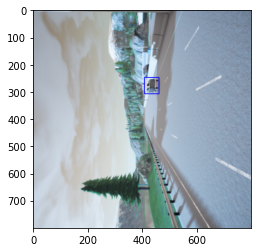

In [48]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = create_model(num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(
    'outputs/model10.pth', map_location=device
))
# model.eval()
model.eval()
test_images = ['saved_image.png']
image = cv2.imread(test_images[0])
orig_image = image.copy()
# BGR to RGB
image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
# make the pixel range between 0 and 1
image /= 255.0
# bring color channels to front
image = np.transpose(image, (2, 0, 1)).astype(np.float)
# convert to tensor
image = torch.tensor(image, dtype=torch.float).cuda()
# add batch dimension
image = torch.unsqueeze(image, 0)
print("Image:", image)
with torch.no_grad():
    outputs = model(image)
detection_threshold = 0.8

# load all detection to CPU for further operations
outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
# carry further only if there are detected boxes
if len(outputs[0]['boxes']) != 0:
    boxes = outputs[0]['boxes'].data.numpy()
    scores = outputs[0]['scores'].data.numpy()
    # filter out boxes according to `detection_threshold`
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    draw_boxes = boxes.copy()
    # get all the predicited class names
    pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

    # draw the bounding boxes and write the class name on top of it
    for j, box in enumerate(draw_boxes):
        cv2.rectangle(orig_image,
                    (int(box[0]), int(box[1])),
                    (int(box[2]), int(box[3])),
                    (0, 0, 255), 2)
        # cv2.putText(orig_image, pred_classes[j], 
        #             (int(box[0]), int(box[1]-5)),
        #             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
        #             2, lineType=cv2.LINE_AA)
    # cv2.imshow('Prediction', orig_image)
    # cv2.waitKey(1)
    # cv2.imwrite(f"../test_predictions/{image_name}.jpg", orig_image,)
    plt.imshow(orig_image)
    plt.savefig("test_prediction.png")
print(f"Image {i+1} done...")
print('-'*50)
print('TEST PREDICTIONS COMPLETE')
# cv2.destroyAllWindows()

In [51]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = create_model(num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(
    'outputs/model10.pth', map_location=device
))
# model.eval()
model.eval()
# test_images = ['saved_image.png']
DIR_TEST = 'data/test_data'
test_images = glob.glob(f"{DIR_TEST}/*")
detection_threshold = 0.8
CLASSES = [
    '0', '1', '2', '3', '4'
]
concatenated_images = torch.tensor([])
for i in range(len(test_images)):
    image_name = test_images[i].split('/')[-1].split('.')[0]
    # image = cv2.imread(test_images[0])
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    if concatenated_images.numel() == 0:
        concatenated_images = image
    else:
        concatenated_images = torch.concat((concatenated_images, image), dim=0)
    
    print("Image:", image)
    with torch.no_grad():
        outputs = model(image)

    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
            # cv2.putText(orig_image, pred_classes[j], 
            #             (int(box[0]), int(box[1]-5)),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
            #             2, lineType=cv2.LINE_AA)
        # cv2.imshow('Prediction', orig_image)
        # cv2.waitKey(1)
        # cv2.imwrite(f"../test_predictions/{image_name}.jpg", orig_image,)
        plt.imshow(orig_image)
        plt.savefig("test_prediction_loc_" + str(i) + ".png")
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')
# cv2.destroyAllWindows()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [50]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = create_model(num_classes=NUM_CLASSES).to(device)
model.load_state_dict(torch.load(
    'outputs/model10.pth', map_location=device
))
# model.eval()
model.eval()
# test_images = ['saved_image.png']
DIR_TEST = 'data/test_data'
test_images = glob.glob(f"{DIR_TEST}/*")
detection_threshold = 0.8
CLASSES = [
    '0', '1', '2', '3', '4'
]
concatenated_images = torch.tensor([])
for i in range(len(test_images)):
    image_name = test_images[i].split('/')[-1].split('.')[0]
    # image = cv2.imread(test_images[0])
    image = cv2.imread(test_images[i])
    orig_image = image.copy()
    # BGR to RGB
    image = cv2.cvtColor(orig_image, cv2.COLOR_BGR2RGB).astype(np.float32)
    # make the pixel range between 0 and 1
    image /= 255.0
    # bring color channels to front
    image = np.transpose(image, (2, 0, 1)).astype(np.float)
    # convert to tensor
    image = torch.tensor(image, dtype=torch.float).cuda()
    # add batch dimension
    image = torch.unsqueeze(image, 0)
    if concatenated_images.numel() == 0:
        concatenated_images = image
    else:
        concatenated_images = torch.concat((concatenated_images, image), dim=0)
print("Concatenated Images Shape:", concatenated_images.shape)

with torch.no_grad():
    outputs = model(concatenated_images)

'''   
    print("Image:", image)
    with torch.no_grad():
        outputs = model(image)

    # load all detection to CPU for further operations
    outputs = [{k: v.to('cpu') for k, v in t.items()} for t in outputs]
    # carry further only if there are detected boxes
    if len(outputs[0]['boxes']) != 0:
        boxes = outputs[0]['boxes'].data.numpy()
        scores = outputs[0]['scores'].data.numpy()
        # filter out boxes according to `detection_threshold`
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        draw_boxes = boxes.copy()
        # get all the predicited class names
        pred_classes = [CLASSES[i] for i in outputs[0]['labels'].cpu().numpy()]

        # draw the bounding boxes and write the class name on top of it
        for j, box in enumerate(draw_boxes):
            cv2.rectangle(orig_image,
                        (int(box[0]), int(box[1])),
                        (int(box[2]), int(box[3])),
                        (0, 0, 255), 2)
            # cv2.putText(orig_image, pred_classes[j], 
            #             (int(box[0]), int(box[1]-5)),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 255, 0), 
            #             2, lineType=cv2.LINE_AA)
        # cv2.imshow('Prediction', orig_image)
        # cv2.waitKey(1)
        # cv2.imwrite(f"../test_predictions/{image_name}.jpg", orig_image,)
        plt.imshow(orig_image)
        plt.savefig("test_prediction_loc_" + str(i) + ".png")
    print(f"Image {i+1} done...")
    print('-'*50)
print('TEST PREDICTIONS COMPLETE')
# cv2.destroyAllWindows()
'''

/tmp/ipykernel_55403/2664510558.py:26: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  image = np.transpose(image, (2, 0, 1)).astype(np.float)


Concatenated Images Shape: torch.Size([6, 3, 600, 800])
X Type: <class 'torch.Tensor'> X Shape: torch.Size([6, 3, 800, 1088])
************************************************** Proposals: tensor([[[ -23.5438,   -6.5232,    8.6058,    6.6177],
         [ -17.1434,  -13.9469,    6.4012,    7.4262],
         [  -7.8694,  -22.7777,    5.1912,    5.7668],
         ...,
         [ 663.5234,  608.1280, 1519.7244,  848.6262],
         [ 814.4178,  472.8192, 1295.0554,  970.1680],
         [ 931.6790,  413.9804, 1169.4893, 1137.7466]],

        [[ -23.8790,   -6.3887,    7.4777,    6.6215],
         [ -17.2477,  -13.8907,    6.2304,    7.2261],
         [  -7.6372,  -23.1488,    5.1526,    4.4740],
         ...,
         [ 666.7250,  608.6601, 1511.0582,  852.1373],
         [ 811.4448,  473.3876, 1292.1265,  971.3497],
         [ 931.9229,  416.0735, 1170.4482, 1136.6174]],

        [[ -23.0458,   -6.6209,    9.7586,    6.9644],
         [ -17.2525,  -13.9368,    6.5143,    7.4550],
         [

/opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [300,0,0], thread: [96,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [300,0,0], thread: [97,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [300,0,0], thread: [98,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator(): block: [300,0,0], thread: [99,0,0] Assertion `index >= -sizes[i] && index < sizes[i] && "index out of bounds"` failed.
/opt/conda/conda-bld/pytorch_1640811806235/work/aten/src/ATen/native/cuda/IndexKernel.cu:93: operator():

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call,so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.

In [50]:
outputs

[{'boxes': tensor([[499.0740, 305.1565, 534.1683, 324.5091],
          [319.1554, 295.3896, 326.6189, 304.5039],
          [319.2034, 296.0228, 326.5106, 305.5069],
          [319.4635, 296.1561, 326.4425, 305.3870],
          [458.4223, 301.4592, 464.0866, 309.5875],
          [458.1772, 301.0164, 464.0881, 309.9141],
          [458.0631, 300.0485, 464.5048, 309.1292],
          [499.3031, 305.8151, 533.0462, 326.1331],
          [319.0707, 295.3933, 326.4928, 305.1089],
          [394.4120, 289.1881, 400.3583, 294.7259],
          [458.0490, 300.4836, 464.1773, 309.6116],
          [494.1196, 302.4437, 538.6104, 325.0189],
          [419.9672, 288.1841, 425.1694, 295.1764],
          [425.0415, 287.4583, 429.6326, 293.2632],
          [413.5129, 287.3714, 419.4713, 294.9806],
          [425.3130, 287.7260, 429.3536, 292.6779],
          [413.5444, 287.6888, 418.9616, 294.0633],
          [420.1195, 288.8530, 424.8775, 294.5943],
          [499.7398, 303.3966, 534.9031, 324.5183],
   

In [69]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(